<a href="https://colab.research.google.com/github/Chimamuelo/Classifier-with-mixup/blob/master/mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
#Select dataset

trainset_img = torchvision.datasets.CIFAR10(root='./data', train=True,
    
                                        download=True)

testset_img = torchvision.datasets.CIFAR10(root='./data', train=False,
    
                                        download=True)
#trainset_img=torchvision.datasets.Caltech101(root='./data', train=True,
    
#                                        download=True)

#test_img=torchvision.datasets.Caltech101(root='./data', train=False,
    
#                                        download=True)
#trainset_img=torchvision.datasets.StanfordCars(root='./data', train=True,
    
#                                        download=True)

#test_img=torchvision.datasets.StanfordCars(root='./data', train=False,
    
#                                        download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(trainset_img),len(testset_img)

(50000, 10000)

In [4]:
#Calculate mean and std
data=trainset_img.data/255

#RGB
mean=data.mean(axis = (0,1,2))
std=data.std(axis = (0,1,2))

print(f"Mean{mean} std{std}")

Mean[0.49139968 0.48215841 0.44653091] std[0.24703223 0.24348513 0.26158784]


In [5]:
#Data augmentation
transformation = transforms.Compose([

    transforms.ToTensor()])
     #transforms.Normalize(mean,std)])

In [6]:
trainset_img = torchvision.datasets.CIFAR10(root='./data', train=True,
    
                                        download=True,transform=transformation)
test_img = torchvision.datasets.CIFAR10(root='./data', train=False,
    
                                        download=True,transform=transformation)
#trainset_img=torchvision.datasets.Caltech101(root='./data', train=True,
    
#                                        download=True,transform=transformation)
#test_img=torchvision.datasets.Caltech101(root='./data', train=False,
    
#                                        download=True,transform=transformation)

#trainset_img=torchvision.datasets.StanfordCars(root='./data', train=True,
    
#                                        download=True,transform=transformation)

#test_img=torchvision.datasets.StanfordCars(root='./data', train=False,
    
#                                        download=True,transform=transformation)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
dataloader=DataLoader(trainset_img,
                      shuffle=True,
                      batch_size=64)
validloader=DataLoader(trainset_img,
                      
                      batch_size=64)

In [8]:
def mixup(data,labels,alpha):
  if alpha:
    lam=torch.rand((1,)).cuda()
    
  else:
    lam=1
  idx=torch.randperm(len(data)).cuda()
  target=labels
  target_2=labels[idx]

  

  mixdata=lam*data+(1-lam)*data[idx,:]

  return mixdata,target,target_2,lam


In [9]:
def loss_func(loss,pred,target,target_2,lam):
  return lam*loss(pred,target)+(1-lam)*loss(pred,target_2)

In [10]:
!pip install torchmetrics attrdict -q

In [11]:
class Model(nn.Module):
  def __init__(self,in_channel,out_channel):
    super().__init__()
    
    self.conv1=nn.Conv2d(in_channel,out_channel,kernel_size=5,stride=1)
    
    #compare stride with max pool, to try this make stride=1
    self.pool=nn.MaxPool2d(2,2)

    self.conv2=nn.Conv2d(out_channel,128,kernel_size=5,stride=1)
    self.adapt=nn.AdaptiveAvgPool2d((1))

    self.linear=nn.Linear(128,120)
    self.linear2=nn.Linear(120,84)
    self.out=nn.Linear(84,10)

    
  def forward(self,x):
    
   # x =F.relu(self.conv1(x))
    x=self.pool(F.relu(self.conv1(x)))

    #x =F.relu(self.conv2(x))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.adapt(x).squeeze()
    #x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.linear(x))
    x = F.relu(self.linear2(x))
    x = self.out(x)
    return x
    
    

In [12]:
model=Model(3,128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


Model(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (adapt): AdaptiveAvgPool2d(output_size=1)
  (linear): Linear(in_features=128, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
import torch.optim as optim
import torchmetrics

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metric = torchmetrics.Accuracy()
metric=metric.to(device)

In [14]:
train_losses_step = []
train_losses = []
valid_losses=[]
#Define train loop
for epoch in range(10):
  running_loss = 0.0
  model.train()
  for i, data in enumerate(dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs=inputs.to(device)
    labels=labels.to(device)
    
    mixdata,target,target_2,lam=mixup(inputs,labels,True)
      # zero the parameter gradients
    optimizer.zero_grad()
    
      # forward + backward + optimize
    outputs = model(mixdata)
   
    
    loss = loss_func(criterion,outputs,target,target_2,lam)
    train_loss=loss.data[0]
    loss.backward()
    optimizer.step()

    batch_acc = metric(outputs,labels.int())
    running_loss += train_loss.item()
    train_losses_step.append(loss.item())
  
  running_loss /= len(dataloader)
  train_losses.append(running_loss)
  train_acc = metric.compute()

  model.eval()
  val_loss=.0
  for i,data in enumerate(validloader,0):
    inputs, labels = data
    inputs=inputs.to(device)
    labels=labels.to(device)
    
    mixdata,target,target_2,lam=mixup(inputs,labels,True)
    outputs = model(mixdata)
   
    
    loss = loss_func(criterion,outputs,target,target_2,lam)

    epoch_loss=loss.data[0]
    batch_acc = metric(outputs,labels.int())
    val_loss += epoch_loss.item()

  val_loss /= len(validloader)
  valid_losses.append(val_loss)
  valid_acc = metric.compute()



  print(f"Epoch: {epoch}, Train loss: {running_loss:.04f} Train acc: {float(train_acc):.04f}, Valid loss: {val_loss:.4f} Vall acc: {float(valid_acc):04f}")

Epoch: 0, Train loss: 2.0591 Train acc: 0.1904, Valid loss: 1.9653 Vall acc: 0.204630
Epoch: 1, Train loss: 1.9201 Train acc: 0.2175, Valid loss: 1.8688 Vall acc: 0.227890
Epoch: 2, Train loss: 1.8431 Train acc: 0.2363, Valid loss: 1.7988 Vall acc: 0.242110
Epoch: 3, Train loss: 1.7830 Train acc: 0.2475, Valid loss: 1.7912 Vall acc: 0.252365
Epoch: 4, Train loss: 1.7493 Train acc: 0.2582, Valid loss: 1.8103 Vall acc: 0.261562
Epoch: 5, Train loss: 1.7220 Train acc: 0.2665, Valid loss: 1.6823 Vall acc: 0.271873
Epoch: 6, Train loss: 1.6918 Train acc: 0.2748, Valid loss: 1.6638 Vall acc: 0.278064
Epoch: 7, Train loss: 1.6709 Train acc: 0.2818, Valid loss: 1.6754 Vall acc: 0.284534
Epoch: 8, Train loss: 1.6473 Train acc: 0.2873, Valid loss: 1.6086 Vall acc: 0.290736
Epoch: 9, Train loss: 1.6370 Train acc: 0.2939, Valid loss: 1.6568 Vall acc: 0.295855


Text(0.5, 0, 'Epoch')

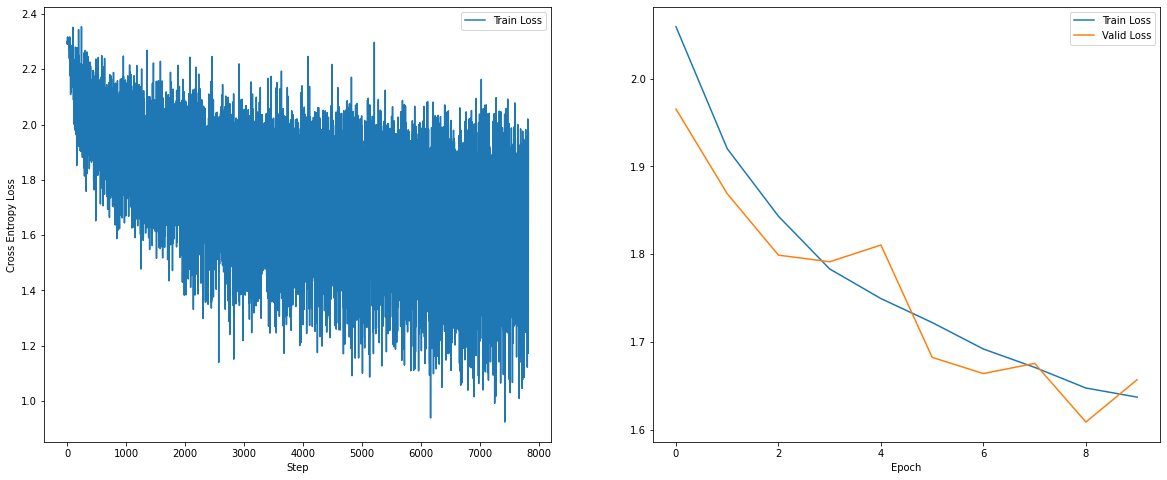

In [15]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
ax1, ax2 = axes
ax1.plot(train_losses_step, label='Train Loss')
ax2.plot(train_losses, label='Train Loss')
ax2.plot(valid_losses, label='Valid Loss')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Step')
ax1.set_ylabel('Cross Entropy Loss')
ax2.set_xlabel('Epoch')

In [16]:
model2=Model(3,128)
model2.to(device)

Model(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (adapt): AdaptiveAvgPool2d(output_size=1)
  (linear): Linear(in_features=128, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
train_losses_step = []
train_losses = []
valid_losses=[]
#Define train loop
for epoch in range(10):
  running_loss = 0.0
  model2.train()
  for i, data in enumerate(dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs=inputs.to(device)
    labels=labels.to(device)
    
    mixdata,target,target_2,lam=mixup(inputs,labels,False)
      # zero the parameter gradients
    optimizer.zero_grad()

      # forward + backward + optimize
    outputs = model2(mixdata)

    
    loss = loss_func(criterion,outputs,target,target_2,lam)
    train_loss=loss
   
    loss.backward()
    optimizer.step()

    batch_acc = metric(outputs,labels.int())
    running_loss += train_loss.item()
    train_losses_step.append(loss.item())
  running_loss /= len(dataloader)
  train_losses.append(running_loss)
  train_acc = metric.compute()

  model2.eval()
  val_loss=.0
  for i,data in enumerate(validloader,0):
    inputs, labels = data
    inputs=inputs.to(device)
    labels=labels.to(device)
    
    mixdata,target,target_2,lam=mixup(inputs,labels,False)
    outputs = model(mixdata)
   
    
    loss = loss_func(criterion,outputs,target,target_2,lam)

    epoch_loss=loss
    batch_acc = metric(outputs,labels.int())
    val_loss += epoch_loss.item()

  val_loss /= len(validloader)
  valid_losses.append(val_loss)
  valid_acc = metric.compute()



  print(f"Epoch: {epoch}, Train loss: {running_loss:.04f} Train acc: {float(train_acc):.04f}, Valid loss: {val_loss:.4f} Vall acc: {float(valid_acc):04f}")


Streaming output truncated to the last 5000 lines.
1126.6192381381989
1128.920589208603
1131.2151036262512
1133.5053668022156
1135.7997298240662
1138.1083116531372
1140.4143517017365
1142.718508720398
1145.029721736908
1147.3275532722473
1149.6278138160706
1151.9373936653137
1154.2495126724243
1156.5441672801971
1158.851868391037
1161.1535727977753
1163.444173336029
1165.7590329647064
1168.0715770721436
1170.3830909729004
1172.673986196518
1174.9778270721436
1177.2851161956787
1179.5792207717896
1181.877932548523
1184.178203344345
1186.490338563919
1188.7901964187622
1191.101265668869
1193.4090580940247
1195.7095222473145
1198.0099458694458
1200.3156316280365
1202.6091566085815
1204.9085838794708
1207.2092916965485
1209.5183637142181
1211.813232421875
1214.121765613556
1216.4253981113434
1218.732125043869
1221.0423731803894
1223.3374741077423
1225.6572892665863
1227.9602828025818
1230.2666008472443
1232.5748782157898
1234.8883786201477
1237.19806599617
1239.5099856853485
1241.824010133

Text(0.5, 0, 'Epoch')

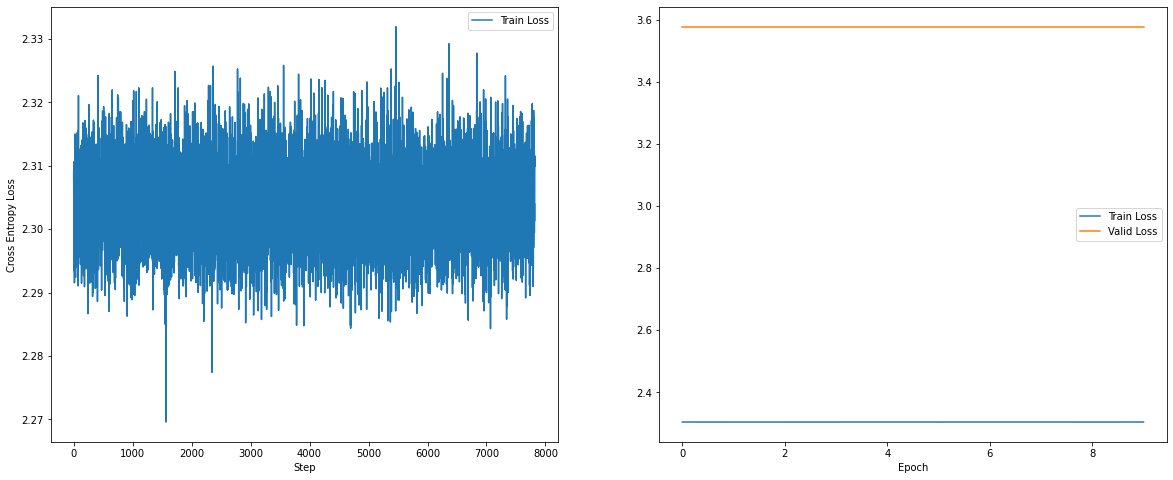

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
ax1, ax2 = axes
ax1.plot(train_losses_step, label='Train Loss')
ax2.plot(train_losses, label='Train Loss')
ax2.plot(valid_losses, label='Valid Loss')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Step')
ax1.set_ylabel('Cross Entropy Loss')
ax2.set_xlabel('Epoch')